
# Sprint 3 — Similarity, Clustering, and Forecasting (Statsmodels)

This notebook demonstrates:
- Ticket **similarity** and **duplicate** detection (TF‑IDF + cosine similarity)
- **Clustering** of tickets into groups (KMeans on LSA-reduced vectors)
- **Forecasting** of ticket volume (statsmodels ARIMA)
- Minimal, working code only — **no unused fluff**

**Input file:** `data/expanded_tickets.json` (provided by project)


In [1]:
# Restart your kernel first, then use this at the very beginning:
import os
import sys

# Set environment variables before ANY imports
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

In [21]:

# Core
import json
import math
import os
from datetime import datetime, timedelta
from typing import List, Dict, Any

# Data / ML
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Forecasting
import statsmodels.api as sm

# Viz
import matplotlib.pyplot as plt

# Config: Matplotlib only, one chart per plot, no custom colors
plt.rcParams.update({"figure.figsize": (8, 5)})


In [5]:

DATA_PATH = 'expanded_tickets.json'


if os.path.exists(DATA_PATH):
    with open(DATA_PATH, 'r') as f:
        data = json.load(f)
else:
    print("WARNING: data/expanded_tickets.json not found. Using embedded sample dataset.")
    data = EMBEDDED_SAMPLE

df = pd.DataFrame(data)
assert 'text' in df.columns, "Dataset must contain a 'text' field"
if 'id' not in df.columns:
    df['id'] = np.arange(1, len(df) + 1)
df.head()


,id,text,category,sentiment
0,1,I cannot access my account. It says my passwor...,account,negative
1,2,I was charged $50 extra on my monthly bill. Th...,billing,negative
2,3,The app keeps crashing when I try to upload fi...,bug,negative
3,4,I would like to request a new feature for dark...,feature,positive
4,5,How do I set up two-factor authentication?,technical,neutral


In [7]:

# Add synthetic created_at timestamps if not present
if 'created_at' not in df.columns:
    # spread uniformly across last 45 days
    end = datetime.now()
    start = end - timedelta(days=44)
    times = [start + timedelta(days=int(i*(44/(len(df)-1)))) for i in range(len(df))] if len(df) > 1 else [end]
    df['created_at'] = times

df['created_at'] = pd.to_datetime(df['created_at'])
df[['id','text','created_at']].head()


,id,text,created_at
0,1,I cannot access my account. It says my passwor...,2025-07-07 04:28:45.368949
1,2,I was charged $50 extra on my monthly bill. Th...,2025-07-08 04:28:45.368949
2,3,The app keeps crashing when I try to upload fi...,2025-07-09 04:28:45.368949
3,4,I would like to request a new feature for dark...,2025-07-10 04:28:45.368949
4,5,How do I set up two-factor authentication?,2025-07-11 04:28:45.368949


In [9]:

# Simple preprocessing function (minimal)
def normalize_text(s: str) -> str:
    s = s.strip().lower()
    return s

texts = df['text'].astype(str).apply(normalize_text).tolist()

# TF-IDF vectorization
tfidf = TfidfVectorizer(min_df=1, max_df=0.9, ngram_range=(1,2))
X = tfidf.fit_transform(texts)
X.shape


(45, 434)

In [11]:

def most_similar(
    query_text: str,
    df: pd.DataFrame,
    tfidf: TfidfVectorizer,
    X_matrix,
    top_k: int = 5,
    exclude_id: int = None
) -> pd.DataFrame:
    q_vec = tfidf.transform([normalize_text(query_text)])
    sims = cosine_similarity(q_vec, X_matrix).ravel()
    res = (
        pd.DataFrame({'id': df['id'].values, 'text': df['text'].values, 'similarity': sims})
        .sort_values('similarity', ascending=False)
    )
    if exclude_id is not None:
        res = res[res['id'] != exclude_id]
    return res.head(top_k)

# Demo: use the first ticket as query
query_row = df.iloc[0]
sim_df = most_similar(query_row['text'], df, tfidf, X, top_k=5, exclude_id=int(query_row['id']))
sim_df


,id,text,similarity
15,16,I forgot my password and cannot reset it.,0.267486
1,2,I was charged $50 extra on my monthly bill. Th...,0.154138
10,11,My account was suspended without warning.,0.151413
39,40,My account was deleted by mistake.,0.150344
27,28,My account got locked after three failed login...,0.113082


In [13]:

def find_duplicates(
    df: pd.DataFrame,
    tfidf: TfidfVectorizer,
    X_matrix,
    threshold: float = 0.85
) -> List[Dict[str, Any]]:
    # Compute cosine similarity matrix (dense for small N)
    sims = cosine_similarity(X_matrix)
    dup_pairs = []
    n = sims.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if sims[i,j] >= threshold:
                dup_pairs.append({
                    'id_1': int(df.iloc[i]['id']),
                    'id_2': int(df.iloc[j]['id']),
                    'sim': float(sims[i,j]),
                    'text_1': df.iloc[i]['text'],
                    'text_2': df.iloc[j]['text']
                })
    return sorted(dup_pairs, key=lambda x: x['sim'], reverse=True)

duplicates = find_duplicates(df, tfidf, X, threshold=0.85)
pd.DataFrame(duplicates).head(10)


""


Original X shape: (45, 434)


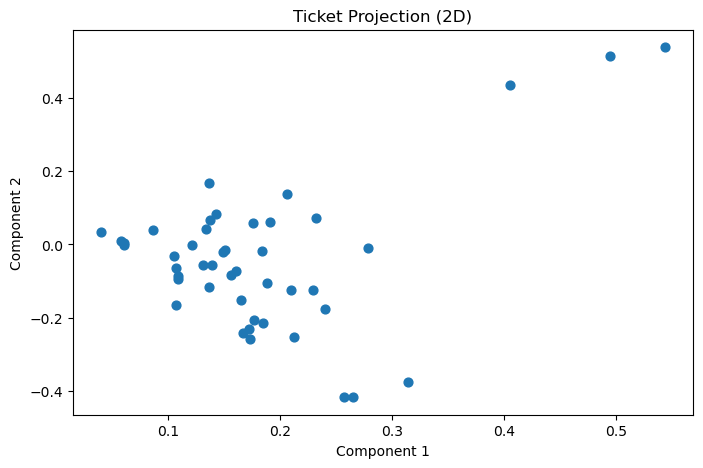

,id,text,cluster
0,1,I cannot access my account. It says my passwor...,1
1,2,I was charged $50 extra on my monthly bill. Th...,1
2,3,The app keeps crashing when I try to upload fi...,0
3,4,I would like to request a new feature for dark...,4
4,5,How do I set up two-factor authentication?,5
5,6,Thank you for fixing the issue so quickly!,2
6,7,My subscription was renewed but I didn't autho...,2
7,8,The search function is not working properly.,0
8,9,Can you add support for mobile notifications?,3
9,10,I need help configuring my email settings.,2


In [23]:
from threadpoolctl import threadpool_limits
# Check X shape and handle edge cases
print(f"Original X shape: {X.shape}")

# Reduce dimensionality with TruncatedSVD (LSA) - fix for small datasets
if X.shape[1] <= 1:
    # If only 1 feature, use it as is
    X_lsa = X.toarray() if hasattr(X, 'toarray') else X
else:
    # Calculate safe number of components
    max_components = min(X.shape[0] - 1, X.shape[1] - 1)
    n_components = min(50, max_components)
    n_components = max(1, n_components)  # Ensure at least 1 component
    
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_lsa = svd.fit_transform(X)

# Choose K - fix for small datasets
if 'category' in df.columns:
    k = len(df['category'].dropna().unique())
    k = max(2, min(k, len(df)))
else:
    k = min(5, len(df))

k = max(2, k)  # Ensure at least 2 clusters

kmeans = AgglomerativeClustering(n_clusters=k)
labels = kmeans.fit_predict(X_lsa)
df['cluster'] = labels

# 2D projection - fix for small feature space
if X.shape[1] >= 2:
    proj = TruncatedSVD(n_components=2, random_state=42).fit_transform(X)
else:
    # If less than 2 features, pad with zeros
    proj = np.column_stack([X.toarray().flatten() if hasattr(X, 'toarray') else X.flatten(), 
                           np.zeros(len(df))])

plt.figure()
plt.scatter(proj[:,0], proj[:,1], s=40)
plt.title("Ticket Projection (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

df[['id','text','cluster']].head(10)

In [25]:

# Compute top terms per cluster (approx via centroid in TF-IDF space)
def top_terms_per_cluster(tfidf, X, labels, top_n=5):
    terms = np.array(tfidf.get_feature_names_out())
    out = {}
    for c in sorted(np.unique(labels)):
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            out[c] = []
            continue
        centroid = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = np.argsort(centroid)[::-1][:top_n]
        out[c] = terms[top_idx].tolist()
    return out

cluster_terms = top_terms_per_cluster(tfidf, X, labels, top_n=5)
cluster_terms


{0: ['the', 'is', 'great', 'the new', 'new'],
 1: ['my', 'was', 'without', 'my account', 'account'],
 2: ['need', 'my', 'help', 'for', 'need help'],
 3: ['add support', 'support', 'you add', 'support for', 'add'],
 4: ['like to', 'like', 'feature', 'to', 'request new'],
 5: ['do', 'how do', 'how', 'do export', 'data']}

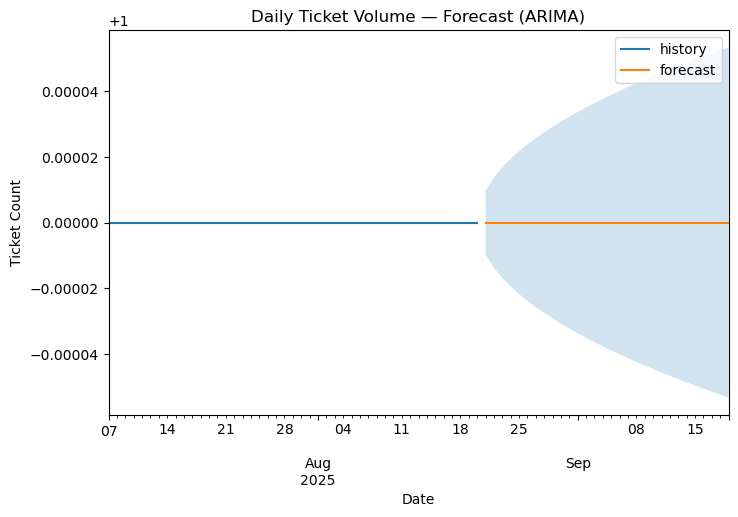

2025-09-15    1.0
2025-09-16    1.0
2025-09-17    1.0
2025-09-18    1.0
2025-09-19    1.0
Freq: D, Name: predicted_mean, dtype: float64

In [27]:

# Prepare daily counts
ts = (
    df.assign(date=df['created_at'].dt.date)
      .groupby('date')['id']
      .count()
      .rename('count')
      .asfreq('D')
      .fillna(0)
)

# Fit ARIMA (auto-order can be tuned; we use simple (1,1,1) as robust default)
model = sm.tsa.ARIMA(ts, order=(1,1,1))
res = model.fit()

# Forecast next 30 days
forecast_steps = 30
fc = res.get_forecast(steps=forecast_steps)
pred = fc.predicted_mean
ci = fc.conf_int()

# Plot historical + forecast
plt.figure()
ts.plot(label="history")
pred.index = pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
pred.plot(label="forecast")

# Confidence interval
plt.fill_between(pred.index, ci['lower count'].values, ci['upper count'].values, alpha=0.2)

plt.title("Daily Ticket Volume — Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Ticket Count")
plt.legend()
plt.show()

pred.tail()


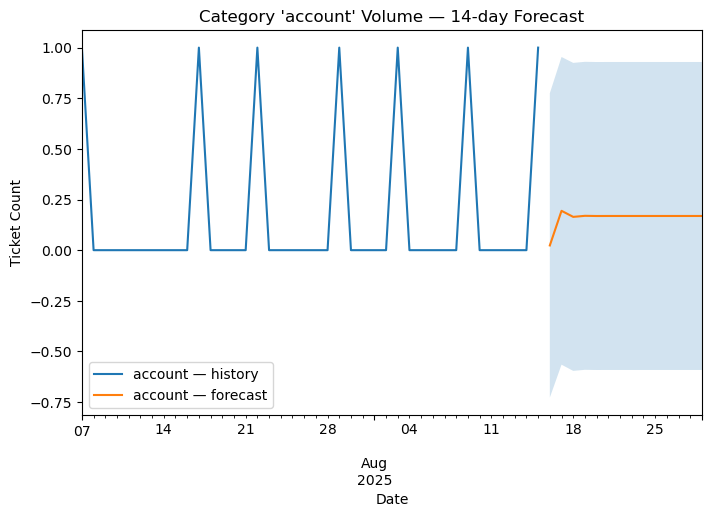

In [29]:

def forecast_series(series: pd.Series, steps: int = 14, order=(1,1,1)):
    # Ensure proper frequency and no NaNs
    series = series.asfreq('D').fillna(0)
    model = sm.tsa.ARIMA(series, order=order)
    res = model.fit()
    fc = res.get_forecast(steps=steps)
    pred = fc.predicted_mean
    ci = fc.conf_int()
    return pred, ci

if 'category' in df.columns:
    cat = sorted(df['category'].unique())[0]
    sub = df[df['category'] == cat].assign(date=df['created_at'].dt.date).groupby('date')['id'].count().rename('count').asfreq('D').fillna(0)
    pred_cat, ci_cat = forecast_series(sub, steps=14)

    plt.figure()
    sub.plot(label=f"{cat} — history")
    pred_cat.index = pd.date_range(sub.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
    pred_cat.plot(label=f"{cat} — forecast")
    plt.fill_between(pred_cat.index, ci_cat['lower count'].values, ci_cat['upper count'].values, alpha=0.2)
    plt.title(f"Category '{cat}' Volume — 14‑day Forecast")
    plt.xlabel("Date")
    plt.ylabel("Ticket Count")
    plt.legend()
    plt.show()


In [31]:

def recommend_similar_for_each(df: pd.DataFrame, tfidf: TfidfVectorizer, X_matrix, top_k=3, min_sim=0.3):
    sims = cosine_similarity(X_matrix)
    recs = {}
    for i, row in df.iterrows():
        # rank others by similarity
        idx = np.argsort(-sims[i])  # descending
        out = []
        for j in idx:
            if j == i:
                continue
            score = float(sims[i, j])
            if score < min_sim:
                break
            out.append({'id': int(df.iloc[j]['id']), 'text': df.iloc[j]['text'], 'similarity': score})
            if len(out) >= top_k:
                break
        recs[int(row['id'])] = out
    return recs

recommendations = recommend_similar_for_each(df, tfidf, X, top_k=3, min_sim=0.35)
# Show sample
{k: recommendations[k] for k in list(recommendations.keys())[:5]}


{1: [],
 2: [],
 3: [],
 4: [{'id': 43,
   'text': "I'd like to request a new reporting feature.",
   'similarity': 0.5103014712262424}],
 5: []}


## ✅ What you now have

- **Similarity search** (`most_similar`) — find related tickets by cosine similarity.
- **Duplicate detection** (`find_duplicates`) — flags near-duplicates using a threshold.
- **Clustering** (TF‑IDF → LSA → KMeans) — groups tickets; `cluster_terms` explain clusters.
- **Forecasting** (statsmodels ARIMA) — next 30‑day volume with confidence intervals.
- **Recommendations** (`recommend_similar_for_each`) — top‑K similar tickets per ticket.

You can wire these results to the Sprint 3 FastAPI endpoints.
